### Importing packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from utils import *

In [2]:
data = pd.read_csv('data/bengaluru_house_prices.csv')
data.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [3]:
print("Size: ",data.shape)
print("Columns: ",', '.join(data.columns))

Size:  (13320, 9)
Columns:  area_type, availability, location, size, society, total_sqft, bath, balcony, price


In [4]:
data.isnull().sum()

area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64

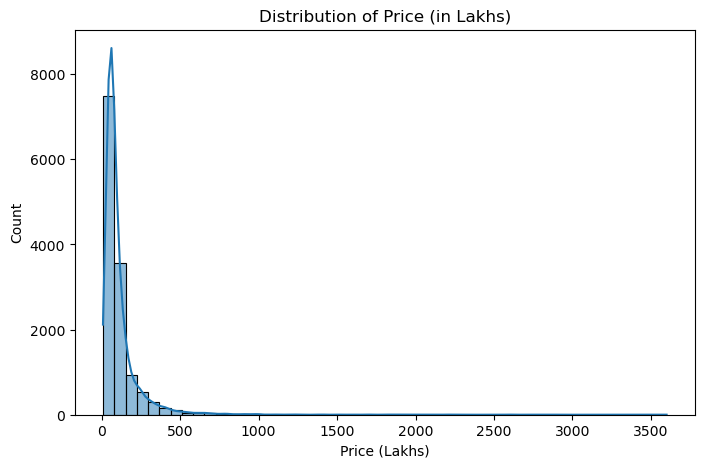

In [5]:
plt.figure(figsize=(8, 5))
sns.histplot(data['price'], bins=50, kde=True)
plt.title('Distribution of Price (in Lakhs)')
plt.xlabel('Price (Lakhs)')
plt.ylabel('Count')
plt.show()

### Data Preprocessing
#### 1. Dropping columns balcony, society, area_type, availability	.
#### 2. Dropping null values of remaining columns.
#### 3. Transforming size string to integer value of BHK.
#### 4. Convert 'total_sqft' to a single numeric value.
#### 5. Creating from price(in lakhs) to price_rupees_per_sqft (in rupees).
#### 6. Removing infrequent locations.

In [6]:
# 1
data2 = data.drop(columns=['balcony','society','area_type','availability'])
data2.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


In [7]:
# 2
data3 = data2.dropna()
data3.shape

(13246, 5)

In [8]:
# 3
data3['bhk'] = data3['size'].apply(convert_to_bhk)

C:\Users\HP\AppData\Local\Temp\ipykernel_9656\2811637666.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3['bhk'] = data3['size'].apply(convert_to_bhk)


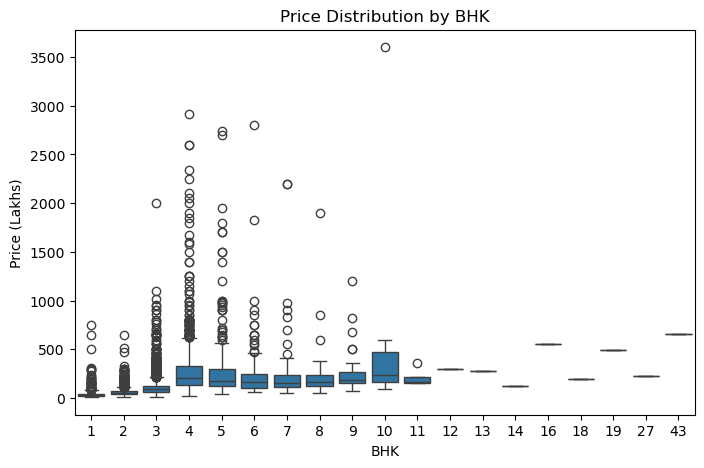

In [9]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='bhk', y='price', data=data3)
plt.title('Price Distribution by BHK')
plt.xlabel('BHK')
plt.ylabel('Price (Lakhs)')
plt.show()

In [10]:
# 4
data3['total_sqft'] = data3['total_sqft'].apply(convert_sqft_to_int)
data3 = data3.dropna(subset=['total_sqft'])

C:\Users\HP\AppData\Local\Temp\ipykernel_9656\2218959489.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3['total_sqft'] = data3['total_sqft'].apply(convert_sqft_to_int)


In [11]:
# 5
data3['price_rupees_per_sqft'] = data3['price']*100000/data3['total_sqft']

In [12]:
# 6
data3['location'] = data3['location'].apply(lambda x: x.strip())
location_counts = data3['location'].value_counts()
rare_locations = location_counts[location_counts <= 10].index
data3['location'] = data3['location'].apply(lambda x: 'other' if x in rare_locations else x)

In [13]:
locations = data3.location.unique()
file_name = 'locations.txt'
with open(file_name,'w') as fp:
    fp.write('\n'.join(locations))
print("Locations written to {0} successfully.".format(file_name))

Locations written to locations.txt successfully.


### Removing Outliers
#### 1. Dropping rows which has less than 300sqft area per room.
#### 2. Removing Location-Wise Price per Sqft Outliers.
#### 3. Removing BHK-Based Pricing Outliers

In [14]:
# 1
data3 = data3[data3['total_sqft'] / data3['bhk'] >= 300]
data3.shape

(12456, 7)

In [15]:
# 2
data4 = remove_pps_outliers(data3)
data4.shape

(10293, 7)

In [16]:
# 3
data5 = remove_bhk_outliers(data4)
data5.shape

(7365, 7)

In [17]:
# Drop unused columns
df_model = data5.drop(['size', 'price_rupees_per_sqft'], axis=1)
df_model.head()

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3
3,1st Block Jayanagar,1200.0,2.0,130.0,3
4,1st Block Jayanagar,1235.0,2.0,148.0,2


### Create dummy variables (one-hot encoding) for location

In [18]:
dummies = pd.get_dummies(df_model['location'], dtype=int)
df_model = pd.concat([df_model.drop('location', axis=1), dummies.drop('other', axis=1)], axis=1)

print("Final shape:", df_model.shape)

Final shape: (7365, 244)


In [19]:
df_model.sample(5)

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
5405,1330.0,2.0,74.0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5499,1025.0,2.0,44.5,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10160,1750.0,3.0,100.0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4402,726.0,2.0,31.0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8415,3500.0,4.0,350.0,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
columns = df_model.columns
file_name = 'columns.txt' 
with open(file_name,'w') as fp:
    fp.write('\n'.join(columns))
print("Columns written to {0} successfully.".format(file_name))

Columns written to columns.txt successfully.


### Independent variables(X), Dependent variable(y), Splitting training and testing set.

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X = df_model.drop('price', axis=1)
y = df_model['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train shape: ", X_train.shape)
print("Test shape:", X_test.shape)

Train shape:  (5892, 243)
Test shape: (1473, 243)


### Testing Different regression models.
#### 1. Linear Regression
#### 2. XGBoost Regression
#### 3. Random Forest

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

In [24]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)
lr_r2 = r2_score(y_test, y_pred)

print("Linear Regression R² Score:", round(lr_r2, 3))

Linear Regression R² Score: 0.865


In [25]:
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
xgb_r2 = r2_score(y_test, y_pred_xgb)

print("XGBoost R² Score:", round(xgb_r2, 3))

XGBoost R² Score: 0.818


In [26]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
rf_r2 = r2_score(y_test, y_pred_rf)

print("Random Forest R² Score:", round(rf_r2, 3))

Random Forest R² Score: 0.82


### Best Model among three: Linear Regression
Plotting the Actual vs Predicted values.

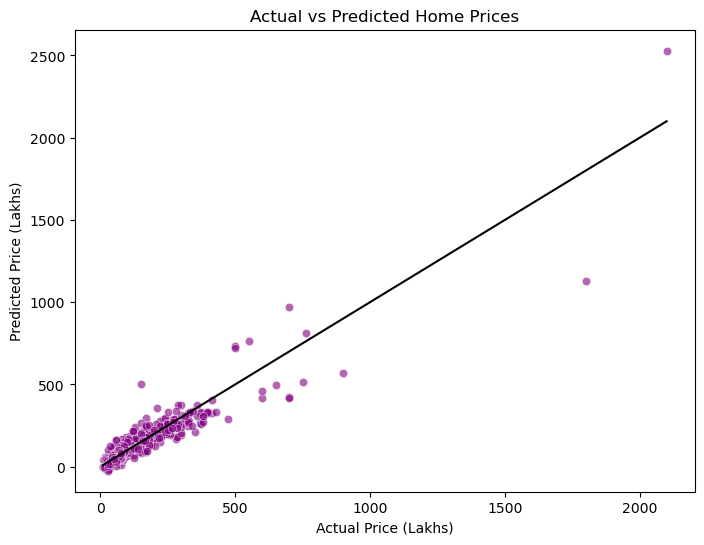

In [27]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'black')  # Diagonal line
plt.xlabel('Actual Price (Lakhs)')
plt.ylabel('Predicted Price (Lakhs)')
plt.title('Actual vs Predicted Home Prices')
plt.show()

#### Save the Model

In [28]:
import joblib
joblib.dump(lr_model, 'house_price_predictor_lr.pkl')

['house_price_predictor_lr.pkl']

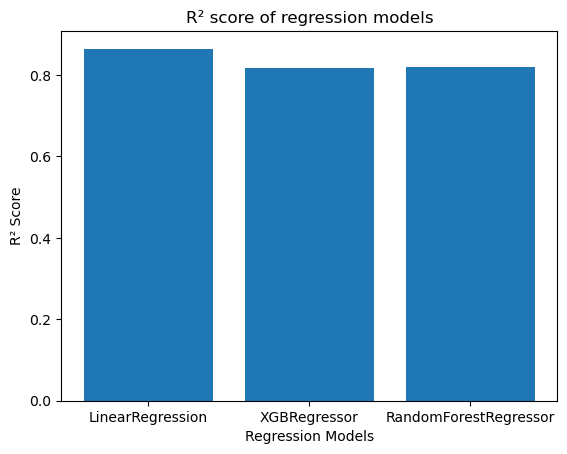

In [29]:
plt.bar(['LinearRegression','XGBRegressor','RandomForestRegressor'], [lr_r2, xgb_r2, rf_r2])
plt.xlabel('Regression Models')
plt.ylabel('R² Score')
plt.title('R² score of regression models')
plt.show()